# Evolve and drive


<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.5. For: 15 December, 2023.*


## Introduction

_Note: part of the background material for this project was already available in [Chapter 5.11 of the textbook](https://mude.citg.tudelft.nl/2023/book/optimization/project.html)._

* We showed in the previous notebook how to use MILP to solve the Road Network Design (RND) Problem 
* You saw that due to a large number of binary variables it takes long to reach a low gap
* Think about larger problems, like the road network of Amsterdam or Shanghai, and it will be even harder!
* Here we show how a metaheuristic such a the genetic algorithm can be used to find good (not necessarily optimal) solutions for the problem in potentially less time


<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Note:</b> You will need to select mude-week-2-5 as your kernel as it includes the required packages.</p></div>

In [ ]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

# Genetic algorithm dependencies. We are importing the pymoo functions that are imporant for applying GA (the package can also apply other methods)
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover #
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.crossover.pntx import PointCrossover # 

In [2]:
# For visualization
from utils.network_visualization import network_visualization
from utils.network_visualization_highlight_link import network_visualization_highlight_links
from utils.network_visualization_upgraded import network_visualization_upgraded

## Genetic algorithm for NDP

As we discussed, it is challenging to use MILP for large-scale NDPs. Therefore, in this assignment, we’re going to use a genetic algorithm to address this problem.

Genetic Algorithms (GAs) are powerful optimization techniques inspired by the process of natural evolution. They have gained prominence in solving complex problems across various fields, ranging from engineering and economics to artificial intelligence. Here, we give a brief overview of Genetic Algorithms, highlighting their fundamental principles, components, and applications in solving optimization problems.
At the heart of a Genetic Algorithm are populations of potential solutions, represented as individuals or chromosomes. These individuals evolve over generations to improve their fitness with respect to the given optimization objective.
Basic Components of a Genetic Algorithm:
* **Population**: A collection of individuals representing potential solutions to the problem.
* **Objective Function** (or fitness function): Quantifies the quality of each individual’s solution with respect to the optimization objective.
* **Selection**: Individuals are chosen based on their fitness to serve as parents for the next generation.
* **Crossover**: Genetic material from parents is combined to create offspring with potentially improved traits.
* **Mutation**: Random changes are introduced in offspring to maintain diversity and explore new solution spaces.
* **Replacement**: New offspring replace some of the least fit individuals in the population.
* **Termination Criteria**: Conditions under which the algorithm stops, e.g., a maximum number of generations or satisfactory fitness level.


### GA steps

Reminding you about the GA steps …
* Initialization (start): A population of random individuals is generated to start the algorithm.
* Evaluation (fitness assessment): The fitness function assesses the quality of each individual’s solution.
* Selection: Individuals with higher fitness have a higher chance of being selected as parents.
* Crossover: Genetic material (part of the solutions) from selected parents is combined to create offspring.
* Mutation: Random changes are introduced to some offspring to maintain diversity.
* Replacement: New offspring replace some individuals in the population.
* Termination (end): The algorithm stops when a termination criterion is met.

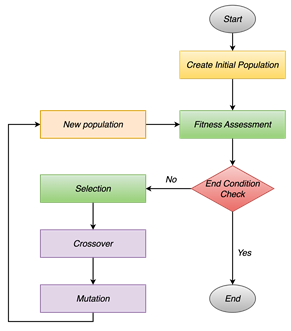

### PyMOO

PyMOO is a Python library that provides a comprehensive and easy-to-use framework for multi-objective optimization (MOO). For this case, we are going to deal with only one objective; nevertheless, this is an useful tool if you have more objectives. In addition, PyMOO easily allows us to define our optimization problem by specifying the objectives, constraints, and decision variables.


## Problem definition and formulation

Here is the problem formulation as presented in the previous Jupyter notebook

$$\begin{align}
  min  \quad  & \sum_{(i,j) \in A}{t^0_{ij} . x_{ij}} + \sum_{(i,j) \in A}{(t^0_{ij}.\beta /c^0_{ij}) . x^2_{ij}} - \sum_{(i,j) \in A}{(t^0_{ij}.\beta /c^0_{ij}) . x^2_{ij} . y_{ij}} + \sum_{(i,j) \in A}{t^0_{ij}.(\beta /c^1_{ij}) . x^2_{ij} . y_{ij}}  \\
  s.t.  \quad \\
  & \sum_{(i,j) \in A}{ y_{ij}} = B \\
  & \sum_{s \in D}{x_{ijs}} = x_{ij} \quad \forall (i,j) \in A  \\
  & \sum_{j \in N; (i,j) \in A}{ x_{ijs}} - \sum_{j \in N; (j,i) \in A}{ x_{jis}} = d_{is} \quad \forall i \in N, \forall s \in D \\
  & y_{ij} \in \{0, 1\} \quad \forall (i,j) \in A \\
  & x_{ij} \geq 0 \quad \forall (i,j) \in A \\
  & x_{ijs} \geq 0 \quad \forall (i,j) \in A, \forall s \in D \\
\end{align}$$


You can check the NDP notebook for details. But here we deal with it slightly differently to be able to use GA. Essentially, we break down the problem into two sub-problems: 1) the traffic assignment (TA) problem: the route choices of the drivers, and the 2) the road network design problem (NDP): where we select which links should be upgraded. We solve the problem by iteratively going between the Traffic assignment and the Design Problem. The idea is for the GA to move to better networks as generations pass which are evaluated by the traffic assignment process that you have learned.
We use Gurobi to solve the Traffic Assignment sub-problems, which provide us with the objective function (or fitness function within the context of GA) value of the decision problem (which will be dealt with using GA). This is usually referred to as the iterative-optimization-assignment method since we iteratively improve the objective function value of the NDP using the assignment problem.

So let's see how that works.


### The network design sub-problem

The network desing is where we use the genetic algorithm. As explained before, GA uses a population of solutions and iteratively improves this population to evolve to new generations of populations with a better objective function value (being that minimization or maximization). In this problem, the decision variables are links for capacity expansion and the objective function value is the total system travel time that we want to minimize.

\begin{align}
  min  \quad  & \sum_{(i,j) \in A}{t^0_{ij} . x_{ij}} + \sum_{(i,j) \in A}{(t^0_{ij}.\beta /c^0_{ij}) . x^2_{ij}} - \sum_{(i,j) \in A}{(t^0_{ij}.\beta /c^0_{ij}) . x^2_{ij} . y_{ij}} + \sum_{(i,j) \in A}{t^0_{ij}.(\beta /c^1_{ij}) . x^2_{ij} . y_{ij}}  \\
  s.t.  \quad \\
  & \sum_{(i,j) \in A}{ y_{ij}} = B \\
  & y_{ij} \in \{0, 1\} \quad \forall (i,j) \in A \\
\end{align}

Where the values of $x_{ij}$ are not decision variables anymore, they will be obtained from solving the Traffic Assignment problem with Gurobi which evaluates the travel times on the network. This part of the problem will not be solved mathematically anymore, the $y_{ij}$ variables are decided by the genetic algorithm through the process you learned.

### The traffic assignment sub-problem

This is just part of the original NDP that assigns traffic to the network based on a set of given capacity values, which are defined based on the values of the DP decision variables (links selected for capacity expansion). The main difference (and the advantage) here is that by separating the binary decision variables, instead of a mixed integer programming problem, which are hard to solve, here we have a quadratic programming problem with continuous decision variables, which will be transformed to a linear problem that Gurobi can solve very fast.

\begin{align}
  min  \quad  & \sum_{(i,j) \in A}{t^0_{ij} . x_{ij}} + \sum_{(i,j) \in A}{(t^0_{ij}.\beta /c^0_{ij}) . x^2_{ij}} - \sum_{(i,j) \in A}{(t^0_{ij}.\beta /c^0_{ij}) . x^2_{ij} . y_{ij}} + \sum_{(i,j) \in A}{t^0_{ij}.(\beta /c^1_{ij}) . x^2_{ij} . y_{ij}}  \\
  s.t.  \quad \\
  & \sum_{s \in D}{x_{ijs}} = x_{ij} \quad \forall (i,j) \in A  \\
  & \sum_{j \in N; (i,j) \in A}{ x_{ijs}} - \sum_{j \in N; (j,i) \in A}{ x_{jis}} = d_{is} \quad \forall i \in N, \forall s \in D \\
  & x_{ij} \geq 0 \quad \forall (i,j) \in A \\
  & x_{ijs} \geq 0 \quad \forall (i,j) \in A, \forall s \in D \\
\end{align}


Where the values of $y_{ij}$ are constant and are defined by GA.

### Summarizing

The following is a diagram that shows what you are finally doing to solve the same problem but with a meta-heuristic approach:

![GAdiagram.png](./figs/GAdiagram.png)

## Data preprocessing

Our data preprocessing steps are similar to the previous notebook. We use some networks from the well-known transportation networks for benchmarking repository as well as a small toy network for case studies of NDPs. the following functions read data from this repository and perform data preprocessing to have the input and the parameters required for our case studies.

In [3]:
# import required packages
import os
import time

# read network file
def read_net(net_file):
    """
       read network file
    """

    net_data = pd.read_csv(net_file, skiprows=8, sep='\t')
    # make sure all headers are lower case and without trailing spaces
    trimmed = [s.strip().lower() for s in net_data.columns]
    net_data.columns = trimmed
    # And drop the silly first and last columns
    net_data.drop(['~', ';'], axis=1, inplace=True)
    # using dictionary to convert type of specific columns so taht we can assign very small (close to zero) possitive number to it.
    convert_dict = {'free_flow_time': float,
                    'capacity': float,
                    'length': float,
                    'power': float
                    }
    
    net_data = net_data.astype(convert_dict)

    # make sure everything makes sense (otherwise some solvers throw errors)
    net_data.loc[net_data['free_flow_time'] <= 0, 'free_flow_time'] = 1e-6
    net_data.loc[net_data['capacity'] <= 0, 'capacity'] = 1e-6
    net_data.loc[net_data['length'] <= 0, 'length'] = 1e-6
    net_data.loc[net_data['power'] <= 1, 'power'] = int(4)
    net_data['init_node'] = net_data['init_node'].astype(int)
    net_data['term_node'] = net_data['term_node'].astype(int)
    net_data['b'] = net_data['b'].astype(float)

    # extract features in dict format
    links = list(zip(net_data['init_node'], net_data['term_node']))
    caps = dict(zip(links, net_data['capacity']))
    fftt = dict(zip(links, net_data['free_flow_time']))
    lent = dict(zip(links, net_data['length']))
    alpha = dict(zip(links, net_data['b']))
    beta = dict(zip(links, net_data['power']))

    net = {'capacity': caps, 'free_flow': fftt, 'length': lent, 'alpha': alpha, 'beta': beta}

    return net


# read OD matrix (demand)
def read_od(od_file):
    """
       read OD matrix
    """

    f = open(od_file, 'r')
    all_rows = f.read()
    blocks = all_rows.split('Origin')[1:]
    matrix = {}
    for k in range(len(blocks)):
        orig = blocks[k].split('\n')
        dests = orig[1:]
        origs = int(orig[0])

        d = [eval('{' + a.replace(';', ',').replace(' ', '') + '}') for a in dests]
        destinations = {}
        for i in d:
            destinations = {**destinations, **i}
        matrix[origs] = destinations
    zones = max(matrix.keys())
    od_dict = {}
    for i in range(zones):
        for j in range(zones):
            demand = matrix.get(i + 1, {}).get(j + 1, 0)
            if demand:
                od_dict[(i + 1, j + 1)] = demand
            else:
                od_dict[(i + 1, j + 1)] = 0

    return od_dict


# read case study data
def read_cases(networks, input_dir):
    """
       read case study data
    """

    # dictionaries for network and OD files
    net_dict = {}
    ods_dict = {}

    # selected case studies
    if networks:
        cases = [case for case in networks]
    else:
        # all folders available (each one for one specific case)
        cases = [x for x in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, x))]

    # iterate through cases and read network and OD
    for case in cases:
        mod = os.path.join(input_dir, case)
        mod_files = os.listdir(mod)
        for i in mod_files:
            # read network
            if i.lower()[-8:] == 'net.tntp':
                net_file = os.path.join(mod, i)
                net_dict[case] = read_net(net_file)
            # read OD matrix
            if 'TRIPS' in i.upper() and i.lower()[-5:] == '.tntp':
                ods_file = os.path.join(mod, i)
                ods_dict[case] = read_od(ods_file)

    return net_dict, ods_dict


# create node-destination demand matrix
def create_nd_matrix(ods_data, origins, destinations, nodes):
    # create node-destination demand matrix (not a regular OD!)
    demand = {(n, d): 0 for n in nodes for d in destinations}
    for r in origins:
        for s in destinations:
            if (r, s) in ods_data:
                demand[r, s] = ods_data[r, s]
    for s in destinations:
        demand[s, s] = - sum(demand[j, s] for j in origins)

    return demand


Now that we have the required functions for reading and processing the data, let's define some problem parameters and prepare the input.

In [4]:
# define parameters, case study (network) list and the directory where their files are
extension_factor = 1.5  # capacity after extension (1.5 means add 50%)

networks = ['SiouxFalls']
networks_dir = os.getcwd() +'/input/TransportationNetworks'


# prep data
net_dict, ods_dict = read_cases(networks, networks_dir)

# Let's load the network and demand (OD matrix) data of the first network (Sioux Falls) to two dictionaries for our first case study.
# WE USE THE SAME NETWORK FROM THE FIRST NOTEBOOK: SIOUX FALLS
# The network has 76 arcs in total
net_data, ods_data = net_dict[networks[0]], ods_dict[networks[0]]

## now let's prepare the data in a format readable by gurobi

# prep links, nodes, and free flow travel times
links = list(net_data['capacity'].keys())
nodes = np.unique([list(edge) for edge in links])
fftts = net_data['free_flow']

## Network Display
We will use the same function we used in the previous notebook to visualize the network. 

In [5]:
coordinates_path = 'input/TransportationNetworks/SiouxFalls/SiouxFallsCoordinates.geojson'

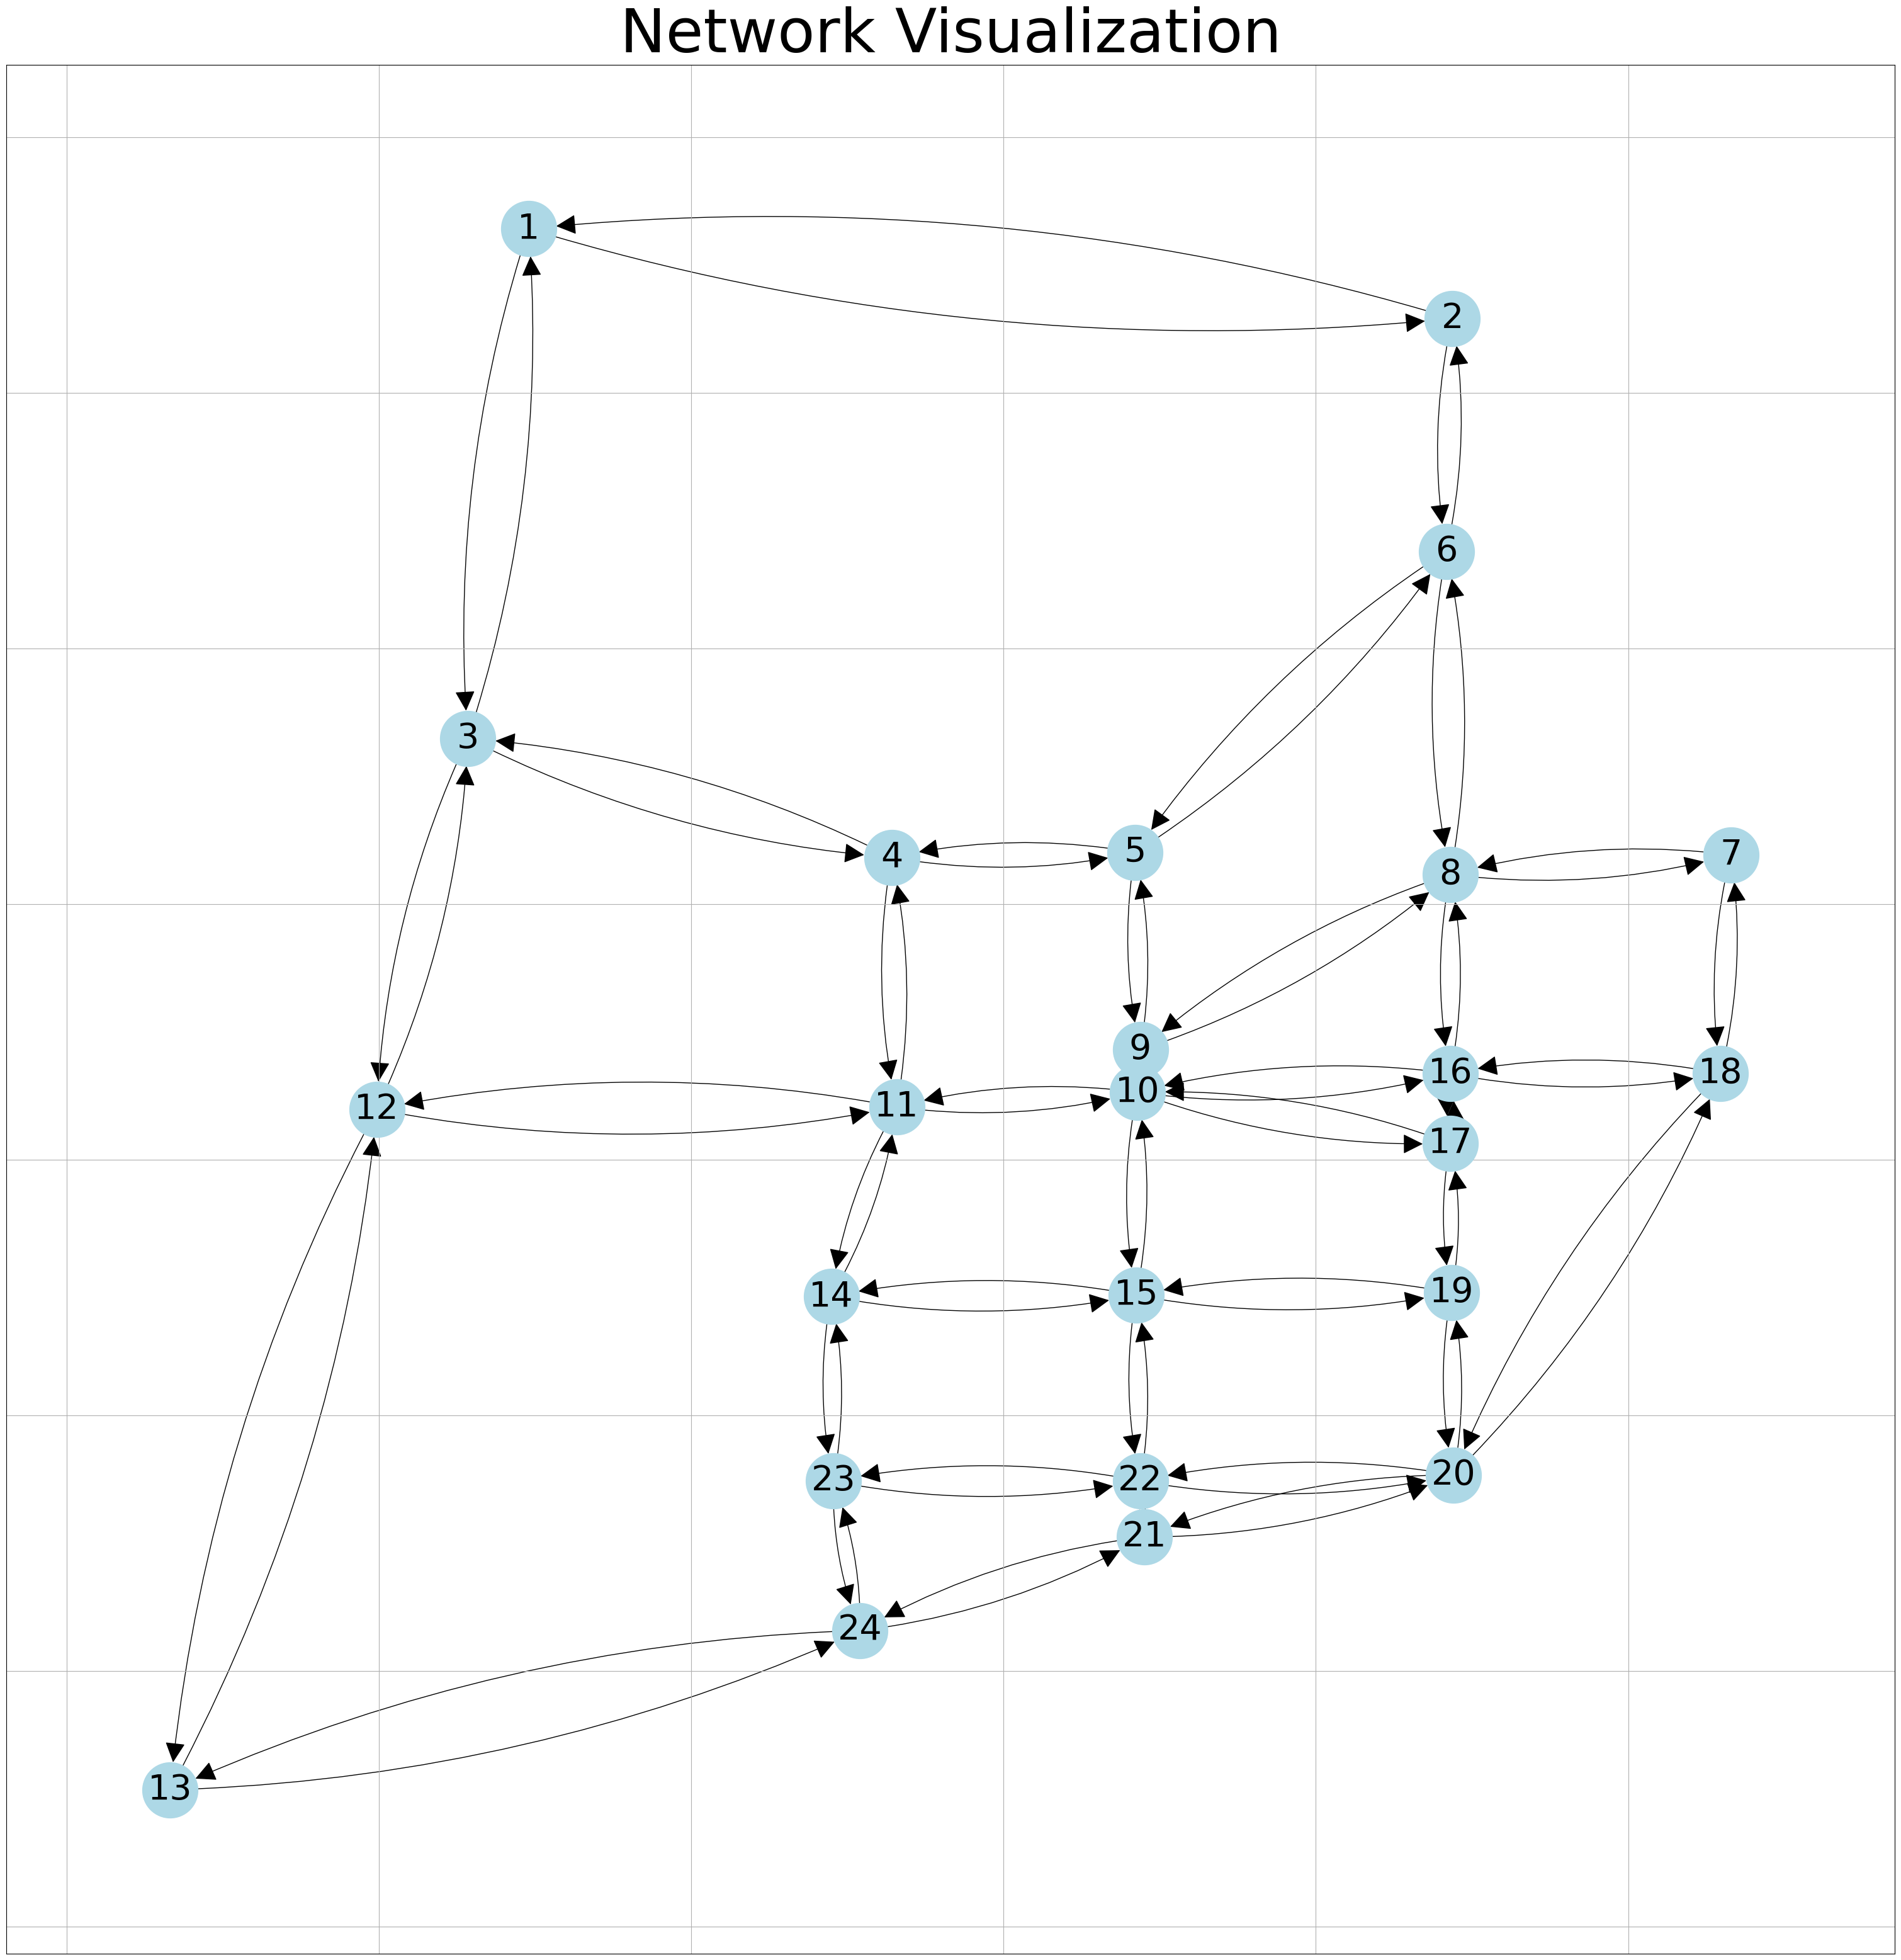

In [6]:
G, pos = network_visualization(link_flow = fftts,coordinates_path= coordinates_path) # the network we create here will be used later for further visualizations!

Now we are ready to build our models!

### Modeling and solving the traffic assignment sub-problem with Gurobi

In this section we build a Gurobi model to solve the Traffic Assignment sub-problems. The decision variables, objective function, and the constraints of this problem were described before.
Here we wrap the code in a function so that we can use it later within the GA.

In [7]:
def ta_qp(dvs, net_data=net_data, ods_data=ods_data, extension_factor=1.5):

    # prep variables
    beta = 2
    links = list(net_data['capacity'].keys())
    nodes = np.unique([list(edge) for edge in links])
    fftts = net_data['free_flow']
    links_selected = dict(zip(links, dvs))

    # define capacity
    cap_normal = {(i, j): cap for (i, j), cap in net_data['capacity'].items()}
    cap_extend = {(i, j): cap * extension_factor for (i, j), cap in net_data['capacity'].items()}
    capacity = {(i, j): cap_normal[i, j] * (1 - links_selected[i, j]) + cap_extend[i, j] * links_selected[i, j]
                for (i, j) in links}

    dests = np.unique([dest for (orig, dest) in list(ods_data.keys())])
    origs = np.unique([orig for (orig, dest) in list(ods_data.keys())])

    # demand in node-destination form
    demand = create_nd_matrix(ods_data, origs, dests, nodes)

    ## create a gurobi model object
    model = gp.Model()
    # just to avoid cluttering the notebook with unnecessary logging output
    model.Params.LogToConsole = 0

    ## decision variables:

    # link flows (x_ij); i: a_node, j: b_node
    link_flow = model.addVars(links, vtype=gp.GRB.CONTINUOUS, name='x')

    # link flows per destination (xs_ijs); i: a_node, j: b_node, s: destination
    dest_flow = model.addVars(links, dests, vtype=gp.GRB.CONTINUOUS, name='xs')

    ## constraints

    # node flow conservation (demand)
    model.addConstrs(
        gp.quicksum(dest_flow[i, j, s] for j in nodes if (i, j) in links) -
        gp.quicksum(dest_flow[j, i, s] for j in nodes if (j, i) in links) == demand[i, s]
        for i in nodes for s in dests
    )

    # link flow conservation (destination flows and link flows)
    model.addConstrs(gp.quicksum(dest_flow[i, j, s] for s in dests) == link_flow[i, j] for (i, j) in links)

    ## objective function (total travel time)
    # total travel time = sum (link flow * link travel time)
    # link travel time = free flow travel time * (1 + (flow / capacity))

    model.setObjective(
        gp.quicksum(link_flow[i, j] * (fftts[i, j] * (1 + (beta * link_flow[i, j]/capacity[i, j]))) for (i, j) in links))


    ## solve
    model.update()
    start_solve = time.time()
    model.optimize()
    solve_time = (time.time() - start_solve)

    # fetch optimal DV and OF values
    link_flows = {(i, j): link_flow[i, j].X for (i, j) in links}
    total_travel_time = model.ObjVal

    return total_travel_time, capacity, link_flows, links_selected

## Modeling with PyMOO

Let's define a model in MyMOO and deal with the links selection problem with the GA.

First, we need to define a problem class.

In [8]:
#If you want to know more about the library that is being used: https://pymoo.org/algorithms/soo/ga.html

class NDP(ElementwiseProblem):

    def __init__(self, budget):

        super().__init__(n_var=len(links),       # number of decision variables (i.e., number of links)
                         n_obj=1,                # for now we use only one objective (total travel time)
                         n_constr=1,             # one constraint for budget, that's because the GA shoud not create unfeasible solutions
                         vtype=bool,             # binary decision variables
                        )
        self.budget = budget

    def _evaluate(self, decision_vars, out, *args, **kwargs):

        # call TA to calculate the objective fucntion, meaning to do the evaluation of the solutions
        total_travel_time,capacity, link_flows, links_selected = ta_qp(decision_vars)

        # the budget constraint
        # In the GA part the only variables are the binary decision variables, don't forget that the traffic assignment that 
        # produces the travel time on the network is done in the evaluation of the solution
        g = sum(decision_vars) - self.budget

        out["F"] = total_travel_time
        out["G"] = g

Now, let's initiate an instance of the problem based on the problem class we defined, and initiate the GA with its parameters. Note that depending on the problem size and the number of feasible links, you might need larger values for population and generation size to achieve good results or even feasible results. Of course this increases the computation times.

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"><p><b>Note:</b> population size <code>pop_size</code> is 10 originally. If you change this, you will see different results. This is problem-dependent!</p></div>

In [9]:
extension_max_no = 40
pop_size = 10

# initiate an instance of the problem with max number of selected links as budget constraint
problem = NDP(budget=extension_max_no)

# initiate the GA with parameters appropriate for binary variables
method = GA(pop_size=pop_size,
            sampling=BinaryRandomSampling(),
            mutation=BitflipMutation(),
            crossover=HalfUniformCrossover()
            # replace HalfUniformCrossover() by PointCrossover(2) for two-point crossover
            )

Now we are ready to minimize the NDP problem using the GA method we defined.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"><p><b>Instructions:</b> Run the GA for 3 minutes initially to observe how the results converge and to understand the process of obtaining the final solution. Once you have familiarized yourself with the mechanism and the behavior of the algorithm, extend the maximum computation time to 10 minutes. Use the results from this extended run as the foundation for addressing the questions outlined in the report. </p></div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"><p><b>Note:</b> Maximum computation time (termination criteria) is set here as a keyword argument.</p></div>

In [10]:

opt_results = minimize(problem,
               method,
               termination=("time", "00:03:00"), #this is maximum computation time
               seed=7,
               save_history=True,
               verbose=True,
               )

print("Best Objective Function value: %s" % opt_results.F)
print("Constraint violation: %s" % opt_results.CV)
print("Best solution found: %s" % opt_results.X)

#To better interpret the results, this is the legend:
#n_gen:  Number of generations
#n_eval: Number of function evaluations
#cv_min: Minimum constraint violation
#cv_avg: Average constraint violation
#f_avg:  Average objective function value
#f_min:  Minimum objective function value

Set parameter Username
Set parameter LicenseID to value 2588551
Academic license - for non-commercial use only - expires 2025-11-21
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       10 |  0.000000E+00 |  0.7000000000 |  1.139479E+07 |  1.125986E+07
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Set parameter LogToC


### Convergence curve

Let's first define some functions (to use later) to get the results and plot them.

In [11]:
def get_results(opt_results):

    number_of_individuals = [] # The number of individuals in each generation
    optimal_values_along_generations = []  # The optimal value found in each generation

    for generation_status in opt_results.history:

        # retrieve the optimum from the algorithm
        optimum = generation_status.opt

        # filter out only the feasible solutions and append and objective space values
        try:
            feas = np.where(optimum.get("feasible"))[0]
            optimal_values_along_generations.append(optimum.get("F")[feas][0][0])
            # store the number of function evaluations
            number_of_individuals.append(generation_status.evaluator.n_eval)
        except:
            #In case a generation does not have any feasible solutions, it will be ignored.
            pass

    return number_of_individuals, optimal_values_along_generations


def plot_results(number_of_individuals, optimal_values_along_generations):

    # Create a scatter plot with enhanced styling
    plt.figure(figsize=(8, 6))  # Set the figure size

    # Create a scatter plot
    plt.scatter(number_of_individuals, optimal_values_along_generations, label='Best objective function', color='blue', marker='o', s=100, alpha=0.7, edgecolors='black', linewidths=1.5)

    # Add labels and a legend with improved formatting
    plt.xlabel('Function evaluations', fontsize=14, fontweight='bold')
    plt.ylabel('Total Travel Time', fontsize=14, fontweight='bold')
    plt.title('Best solution evolution', fontsize=16, fontweight='bold')
    plt.legend(loc='upper right', fontsize=12)

    # Customize the grid appearance
    plt.grid(True, linestyle='--', alpha=0.5)

    # Customize the tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a background color to the plot
    plt.gca().set_facecolor('#f2f2f2')

    # Show the plot
    plt.show()

Now let's use these functions to plot the results.


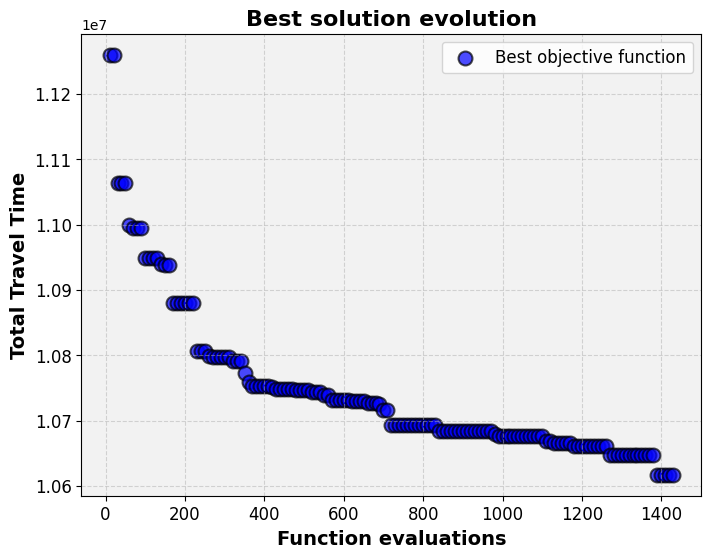

In [12]:
number_of_individuals, optimal_values_along_generations = get_results(opt_results)

plot_results(number_of_individuals, optimal_values_along_generations)

## Network Visualization
Same as the previous notebook we use link_flows, links_selected to visualize our results on the network.

In [13]:
travel_time, capacity, link_flows, links_selected= ta_qp(dvs=opt_results.X, net_data=net_data, ods_data=ods_data, extension_factor=1.5)

Set parameter LogToConsole to value 0


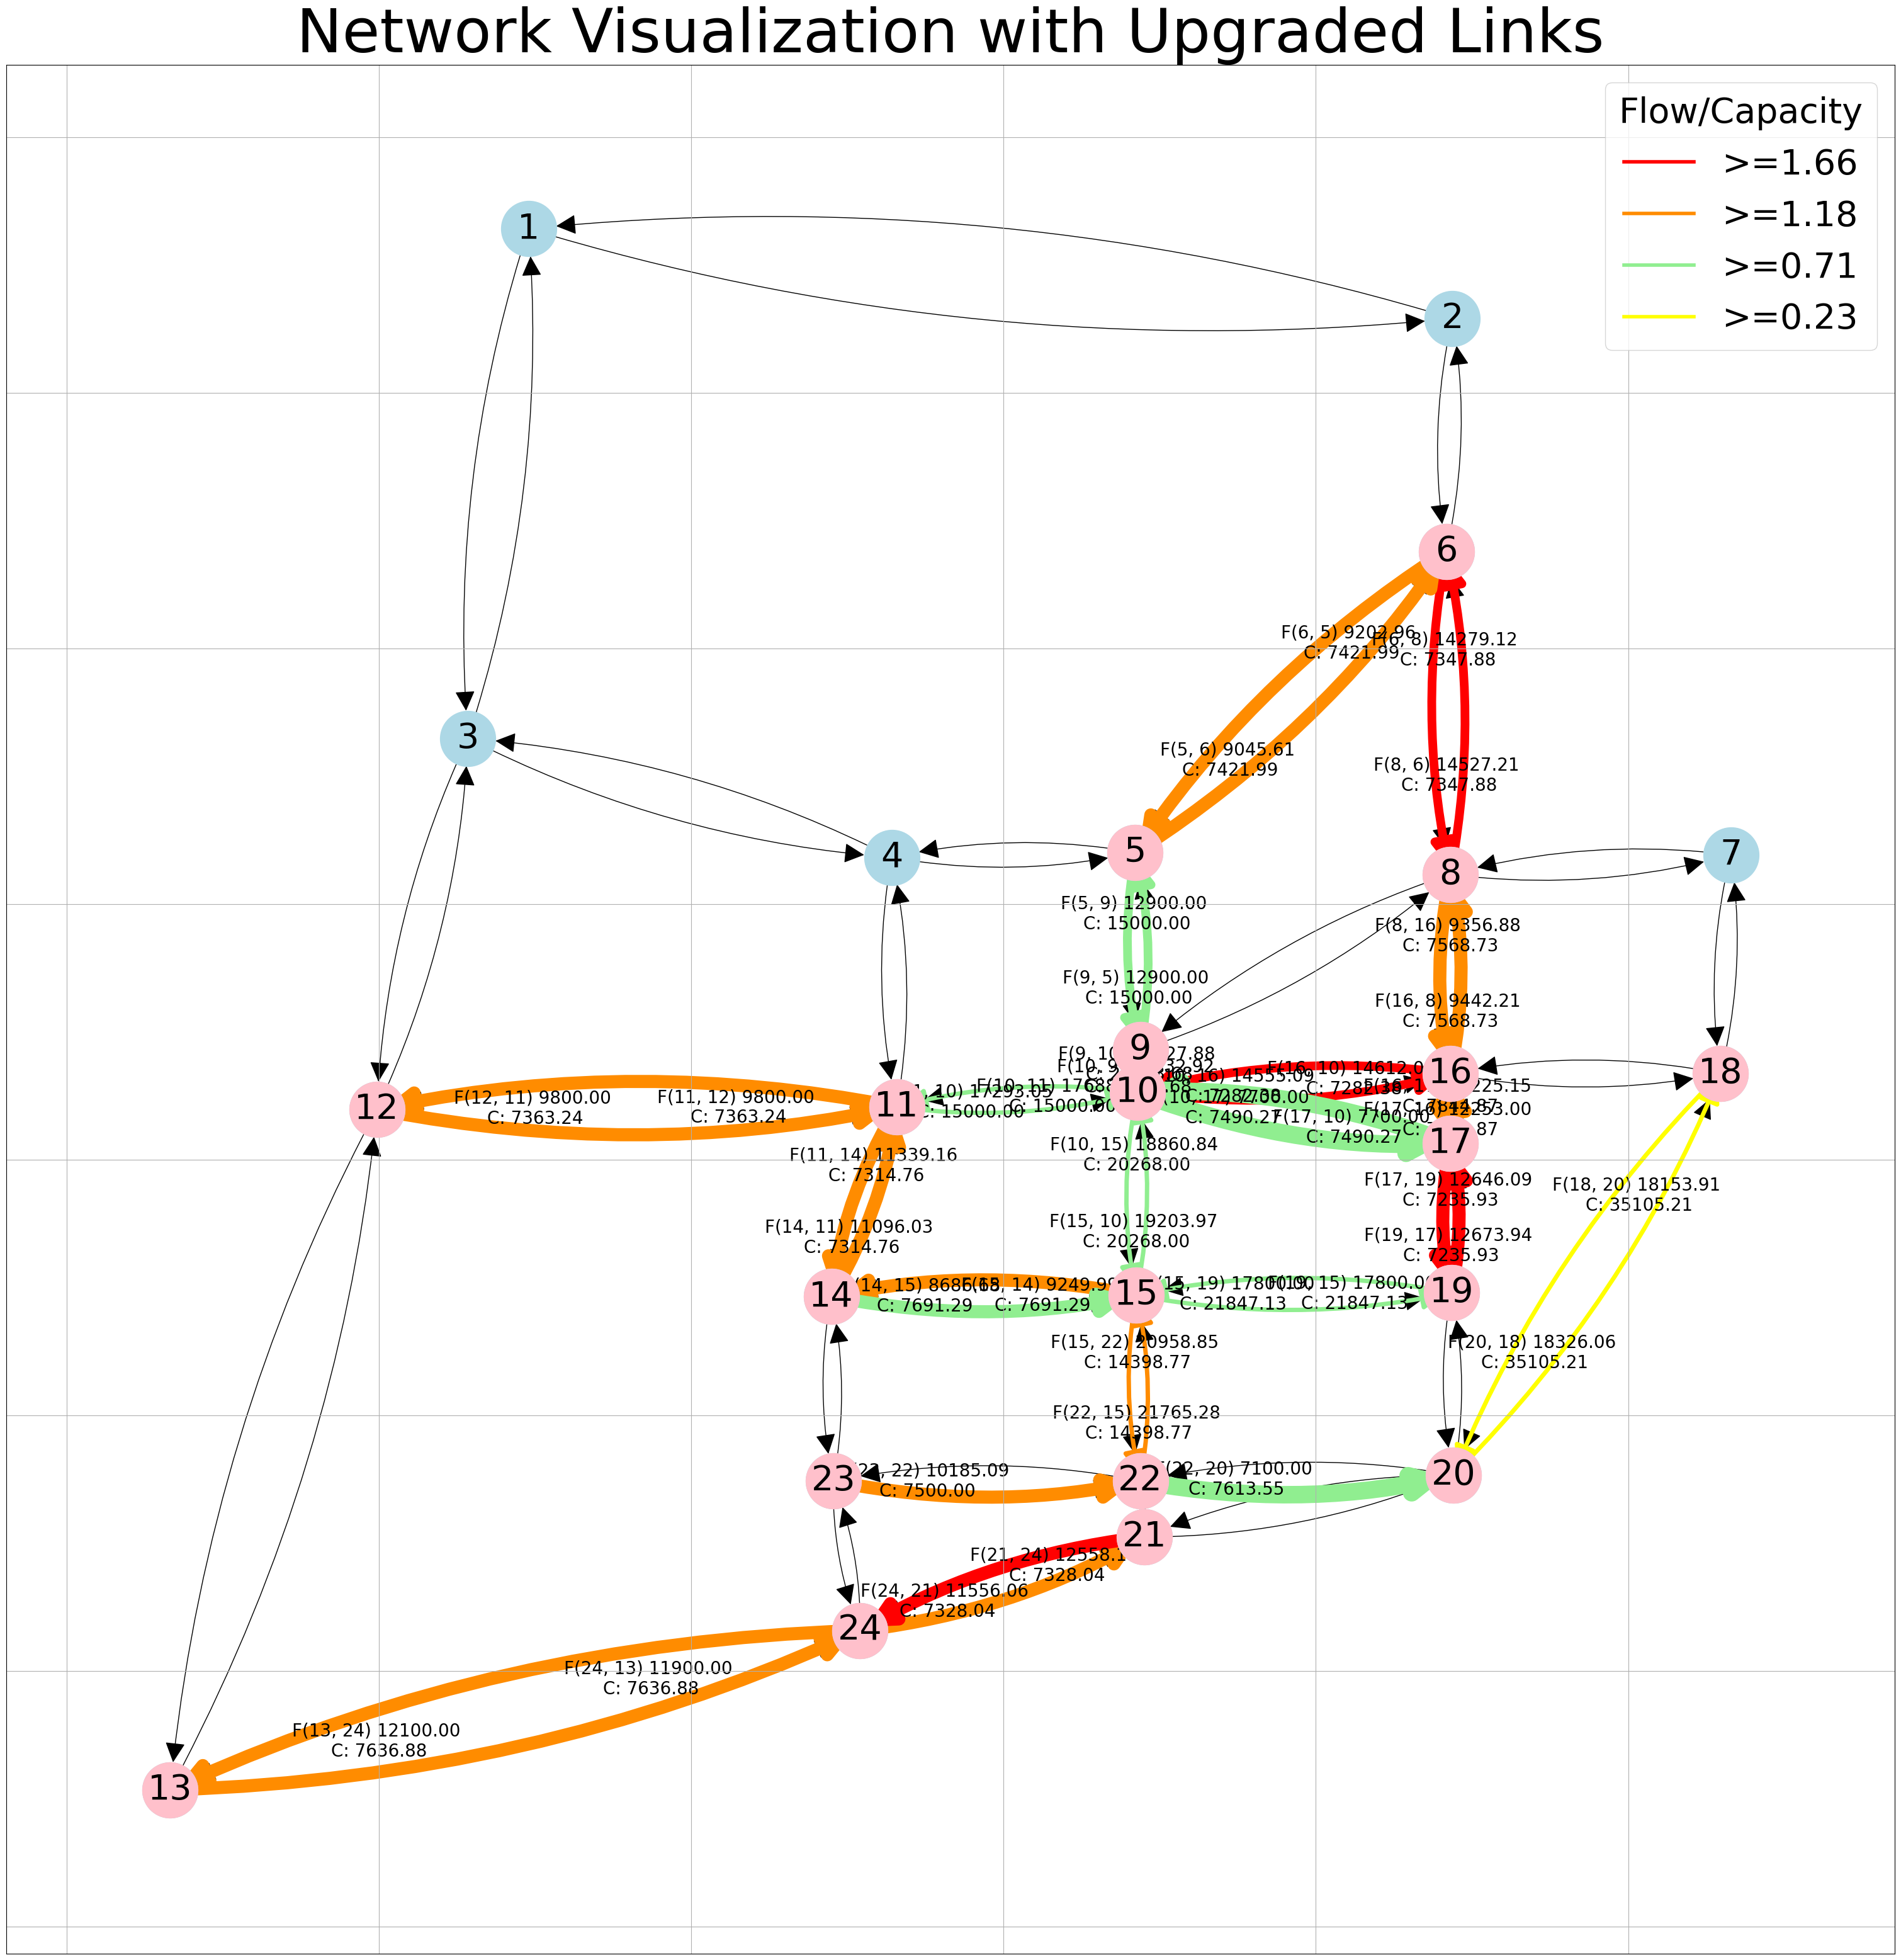

In [14]:
# Plot results
# To see the values for all the links just turn on the labels in the function below.
network_visualization_upgraded (G = G, pos=pos, link_flow=link_flows, capacity_new=capacity ,link_select=links_selected, labels='off')

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.